In [1]:
import sys
import os
sys.path.append('/Users/physarah/Development/dayobs/python')
import calibs
import utils
import reduction
import matplotlib.dates as mdates
import photometry
import corner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import itertools
from datetime import timedelta
import warnings
import seaborn as sns
from scipy.optimize import least_squares
warnings.filterwarnings('ignore')
import sep
import json
import uuid 
from os import listdir
from os.path import isfile, join
from astropy.io import fits
from astropy.visualization import PowerStretch
import astropy.units as u
from astropy.time import Time as TiMe
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.coordinates import get_body, get_sun
import json
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.convolution import convolve, convolve_fft
from PIL import Image
from datetime import datetime, timedelta

sys.path.append('/Users/physarah/Development/dayobs/notebooks')

import daytime_obs_functions as do
from PyAstronomy import pyasl

sys.path.append('/Users/physarah/Development/dayobs/scripts')

import dayobs_funcs as di
import adnav as adnav
from IPython.core.display import display, HTML
from astroquery.gaia import Gaia
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime, timedelta
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

### Convenience Functions

In [2]:
def calibrate_huntsman(r_inst, airmass,
                       a1_optimal, a2_optimal):

    huntsman_calibs = r_inst - a1_optimal - a2_optimal * airmass 
    return(huntsman_calibs)

def crop_around_point(image, center, crop_size):
    half_width = crop_size[0] // 2
    half_height = crop_size[1] // 2

    start_row = max(0, center[0] - half_height)
    start_col = max(0, center[1] - half_width)
    end_row = min(image.shape[0], center[0] + half_height)
    end_col = min(image.shape[1], center[1] + half_width)

    cropped_image = image[start_row:end_row, start_col:end_col]
    return cropped_image

def save_fits_image(data, filename):
    # Create a FITS header
    header = fits.Header()
    header['SIMPLE'] = True
    header['BITPIX'] = -64  # 64-bit floating point format
    header['NAXIS'] = 2  # 2D image
    header['NAXIS1'] = data.shape[1]  # Width of the image
    header['NAXIS2'] = data.shape[0]  # Height of the image

    # Save the data and header to a FITS file
    hdu = fits.PrimaryHDU(data, header=header)
    hdul = fits.HDUList([hdu])
    hdul.writeto(filename, overwrite=True)
    
def get_instrumental_fluxes(df):

    (gband_tp,
     rband_tp,
     hband_tp,
     sband_tp) = reduction.get_filter_qe_curves()
    (correction_rband,
     correction_gband,
     correction_hband,
     correction_sband) = reduction.get_throuhgput_qe_corrections(gband_tp, rband_tp, hband_tp, sband_tp)

    df['m_inst'] = -2.5*np.log10((df['target_sum']/df['exposure_time'])*(1/correction_gband))
    
    df['m_inst_sky'] = -2.5 * \
        np.log10(((df['sky_mean']/1.24)/df['exposure_time'])*(1/correction_rband))

    return(df)


def read_json_data(json_file):
    file_names = []
    imported_x_clicks = []
    imported_y_clicks = []

    with open(json_file) as json_file:
        for line in json_file:
            data = json.loads(line)
            file_name, click_data = list(data.items())[0]
            file_names.append(file_name)
            imported_x_clicks.append(click_data['x_clicks'])
            imported_y_clicks.append(click_data['y_clicks'])

    return file_names, imported_x_clicks, imported_y_clicks

### Import Data and Flats Master

In [3]:
master_flat_field_normalized = np.array(fits.getdata("/Volumes/tycho/other/sarahs-ssa/01_18_24/Flats/master_rband_flat.fits"))
science_files = "/Volumes/tycho/other/sarahs-ssa/01_18_24/starlink-30775-58139U/CapObj/2024-01-18_06_54_35Z"
science_target_paths = [f.path for f in os.scandir(science_files) if not f.path.endswith('txt')]
science_target_paths = [f for f in science_target_paths if not f.endswith('.DS_Store')]

### Calibrate the Science Frames with Master Flat

In [4]:
calibrated_science_frames = []
exposure_times_sat = []
gains_sat = []
datetimes_sat = []

for file_path in science_target_paths:
    
    science_data = np.array(fits.getdata(file_path))
    with fits.open(file_path) as hdul:
        hdr = hdul[0].header
        
    exposure_times_sat.append((hdr['EXPOINUS'] * u.microsecond).to(u.s).value)
    gains_sat.append(hdr['GAIN'])
    datetimes_sat.append(hdr['DATE-OBS'])
    
    calibrated_frame = science_data / master_flat_field_normalized
    calibrated_science_frames.append(calibrated_frame)

In [6]:
file_names, imported_x_clicks, imported_y_clicks = read_json_data('/Users/physarah/Desktop/starlink-30775-58139U_locations.json')

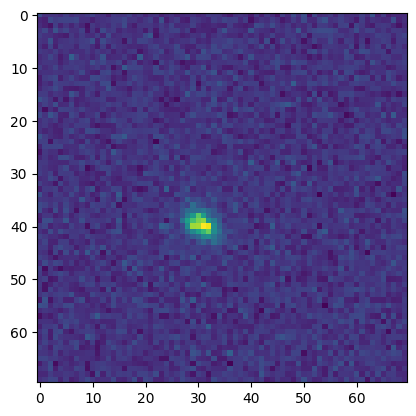

In [7]:
ints = 20
im_out = crop_around_point(calibrated_science_frames[ints], 
                  center = [imported_y_clicks[ints][0], imported_x_clicks[ints][0]], 
                  crop_size = [70,70])

plt.imshow(im_out)

In [8]:
(source_mean, source_median, source_sum, source_rate, 
sky_mean, sky_median, sky_sum, sky_rate,
target_mean, target_median, target_sum, target_rate,
sc_area, bk_area, times) = ([],[],[],[],[],[],[],[],[],[],[],[],[],[],[])

exposure_times_sat_cropped = []
gains_sat_cropped = []
datetimes_sat_cropped = []

In [9]:
for i in np.arange(0,len(calibrated_science_frames)):
    try:
        field = calibrated_science_frames[i]
        test_image = crop_around_point(field, 
                  center = [imported_y_clicks[i][0], imported_x_clicks[i][0]], 
                  crop_size = [70,70])

        flat_index_of_max_value = np.argmax(test_image)
        max_coordinates = np.unravel_index(flat_index_of_max_value, test_image.shape)
        max_value = test_image[max_coordinates]

        times.append(datetimes_sat[i])
        (source_mean1, source_median1, source_sum1, source_rate1, 
        sky_mean1, sky_median1, sky_sum1, sky_rate1,
        target_mean1, target_median1, target_sum1, target_rate1,
        sc_area1, bk_area1) = di.get_source_infos(data = test_image, 
                                             x_pix = max_coordinates[1], 
                                             y_pix = max_coordinates[0],
#                                              x_pix = sources['xcentroid'],
#                                              y_pix = sources['ycentroid'], 
                                             exp_time = exposure_times_sat[i],
                                             sc_radius = 11,
                                             bk_inner_radius = 13,
                                             bk_outer_radius = 15)

        source_mean.append(source_mean1)
        source_median.append(source_median1)
        source_sum.append(source_sum1)
        source_rate.append(source_rate1)

        sky_mean.append(sky_mean1)
        sky_median.append(sky_median1)
        sky_sum.append(sky_sum1)
        sky_rate.append(sky_rate1)

        target_mean.append(target_mean1)
        target_median.append(target_median1)
        target_sum.append(target_sum1)
        target_rate.append(target_rate1)

        sc_area.append(sc_area1)
        bk_area.append(bk_area1)
        
        exposure_times_sat_cropped.append(exposure_times_sat[i])
        gains_sat_cropped.append(gains_sat[i])
        datetimes_sat_cropped.append(datetimes_sat[i])
        
    except Exception as err:
        print(err)
        pass   

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range


In [10]:
dicts_out = {'source_mean':source_mean,
            'source_median':source_median,
             'source_sum':source_sum,
             'source_rate':source_rate,
            'sky_mean':sky_mean,
            'sky_median':sky_median,
            'sky_sum':sky_sum,
            'sky_rate':sky_rate,
            'target_mean':target_mean,
            'target_median':target_median,
            'target_sum':target_sum,
            'target_rate':target_rate,
            'sc_area':sc_area,
            'bk_area':bk_area,
            'exposure_time':exposure_times_sat_cropped,
            'datetimes_sat':datetimes_sat_cropped,
            'gains_sat':gains_sat_cropped}

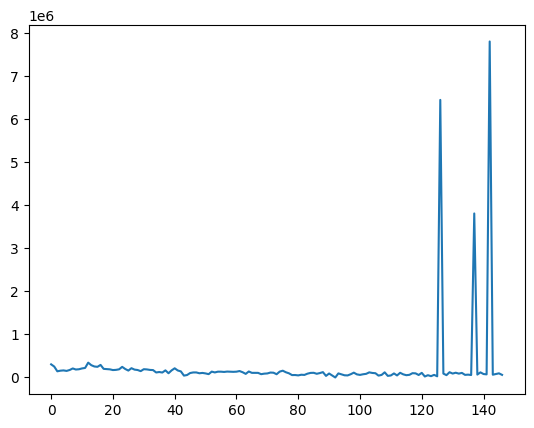

In [11]:
plt.plot(np.arange(0,len(dicts_out['target_sum'])), dicts_out['target_sum'])

In [12]:
data = pd.DataFrame.from_dict(dicts_out)

In [13]:
a1_optimal_r_alld, a2_optimal_r_alld, a3_optimal_r_alld = (-21.75804035739125, 0.35777116581783436, 0.04368023121736458)

In [14]:
a1_optimal_g_alld, a2_optimal_g_alld, a3_optimal_g_alld = (-22.042611663653954, 0.2559905311223672, -0.12935216657557883)

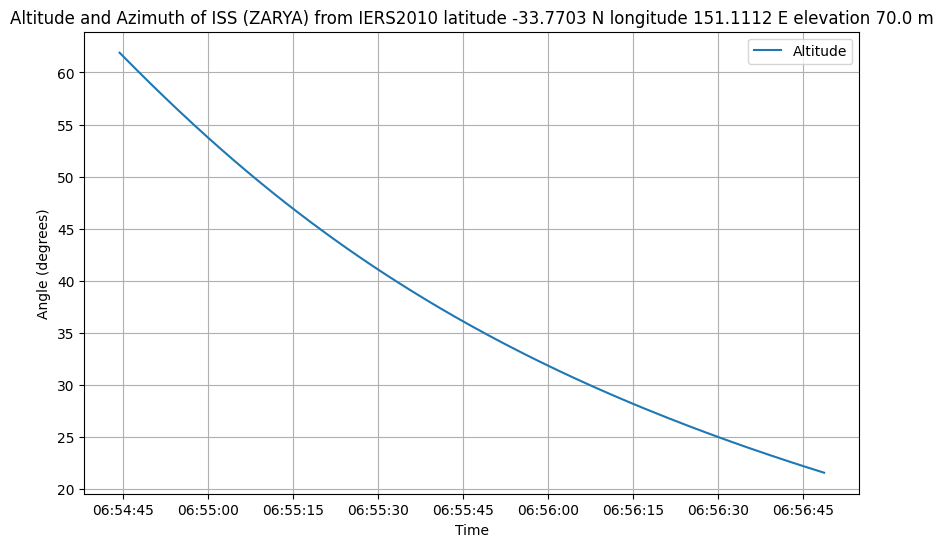

In [16]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import pytz
import math
from math import radians
%matplotlib inline
# Custom TLE data

tle_line1 = "STARLINK-30775"     # up to date as of 24th Jan 2024     
tle_line2 = "1 58139U 23162X   24017.91668981  .00032823  00000+0  24342-2 0  9996"
tle_line3 = "2 58139  43.0013  61.4210 0001237 254.9302 200.9332 15.02525504  5802"

ts = load.timescale()
satellite = EarthSatellite(tle_line2, tle_line3, name="ISS (ZARYA)")        
observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70)

utc_datetime = pd.to_datetime(data['datetimes_sat']) - timedelta(hours=0) 
#times_datetime = [t.utc_datetime() for t in times]

times = []
for timestamp_pd in utc_datetime:
    TIME_PD = timestamp_pd.replace(tzinfo=pytz.utc)
    time_sf = ts.utc(TIME_PD)
    times.append(time_sf)

altitudes = []
azimuths = []
sep_angle = []
distance_list = []

for time in times:
    topocentric = (satellite - observer_location).at(time)
    satellite_position = satellite.at(time)
    earth_radius = 6371.0  # Radius of the Earth in kilometers
    satellite_position = satellite.at(time)

    observer_latitude = radians(-33.7703)  # Convert to radians
    observer_longitude = radians(151.1112)  # Convert to radians
    
    earth_radius_km = 6371.0  # Approximate Earth radius in kilometers

    delta_longitude = satellite_position.subpoint().longitude.radians - observer_longitude
    delta_latitude = satellite_position.subpoint().latitude.radians - observer_latitude

    a = (pow(math.sin(delta_latitude / 2), 2) +
         math.cos(observer_latitude) * math.cos(satellite_position.subpoint().latitude.radians) *
         pow(math.sin(delta_longitude / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_list.append(distance_km)

    alt, az, _ = topocentric.altaz()
    altitudes.append(alt.degrees)
    azimuths.append(az.degrees)
    
times_datetime = [t.utc_datetime() for t in times]

plt.figure(figsize=(10, 6))
plt.plot(times_datetime, altitudes, label="Altitude")
#plt.plot(times_datetime, azimuths, label="Azimuth")
plt.xlabel("Time")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.title(f"Altitude and Azimuth of {satellite.name} from {observer_location}")
plt.grid()
plt.show()

In [17]:
data['airmass'] = pyasl.airmassSpherical(90-np.array(altitudes), 64)
data = get_instrumental_fluxes(data)
data_calibed = calibrate_huntsman(data['m_inst'], data['airmass'], a1_optimal_r_alld, a2_optimal_r_alld)

In [18]:
data['calibed_mags'] = data_calibed
data['altitude'] = altitudes
data['azimuth'] = azimuths
data['utc'] = utc_datetime
data['zenith_angle'] = 90 - np.array(altitudes)
data['km_distance'] = distance_list

Text(0, 0.5, "Huntsman Pathfinder r'")

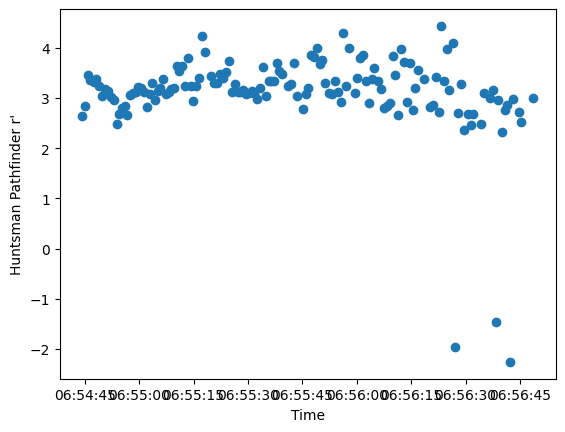

In [19]:
filtered_df = data[abs(data['calibed_mags'].diff().fillna(0)) <= 0.3]

#data = data[data['calibed_mags']>0]
plt.scatter(pd.to_datetime(data['datetimes_sat']), data['calibed_mags'])
plt.xlabel("Time")
plt.ylabel("Huntsman Pathfinder r'")
#plt.ylim(3.5,1.5)


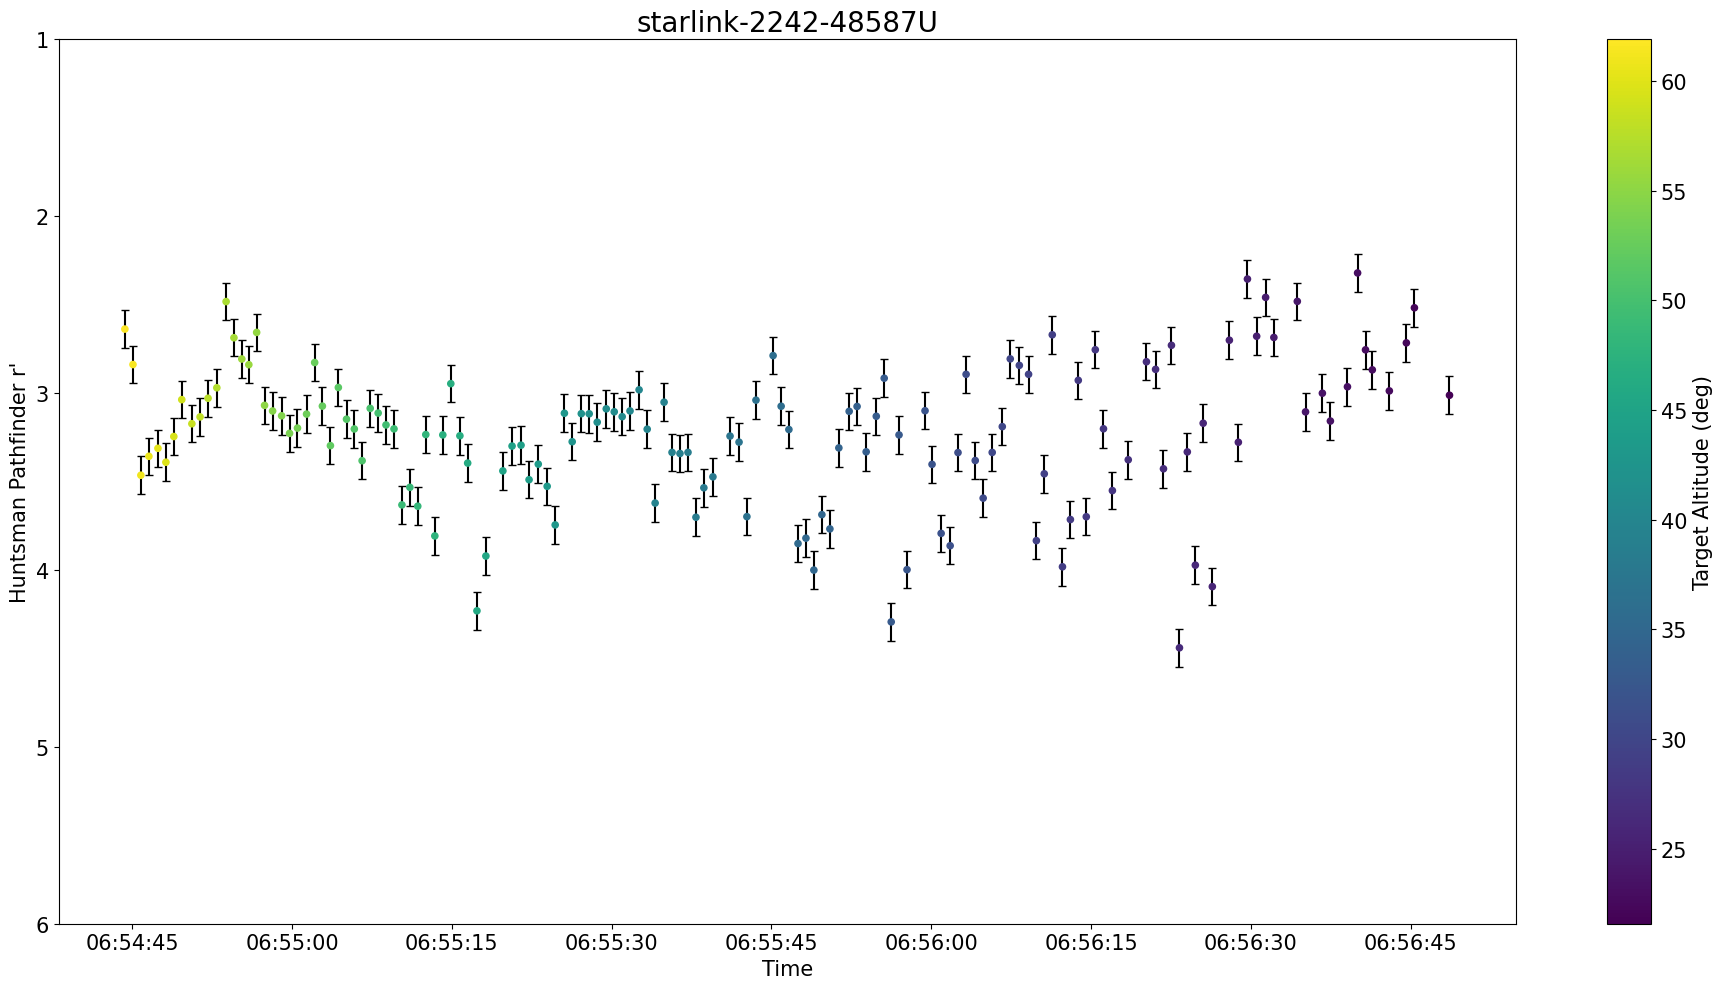

In [20]:
error = 0.106

plt.figure(figsize = (19,10))
plt.title("starlink-2242-48587U", fontsize = 20)
plt.errorbar(x = pd.to_datetime(data['datetimes_sat']), y = data['calibed_mags'], yerr=[[error]*len(data['calibed_mags']),
                                                                 [error]*len(data['calibed_mags'])], ls = "", capsize = 3, color = 'black')
plt.scatter(x = pd.to_datetime(data['datetimes_sat']), y = data['calibed_mags'], s = 20, c = data['altitude'], zorder = 10, cmap = 'viridis')
plt.xlabel("Time", fontsize=15)
plt.ylabel("Huntsman Pathfinder r'", fontsize=15)
cbar = plt.colorbar()
cbar.set_label("Target Altitude (deg)", fontsize=15)
cbar.ax.tick_params(labelsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.clim(25,50)
#plt.xlim(pd.to_datetime('2023-03-06 12:24:50'), pd.to_datetime('2023-03-06 12:27:45'))
plt.ylim(6,1)
plt.tight_layout()
#plt.savefig("/Users/physarah/Desktop/SAOCOM.png")


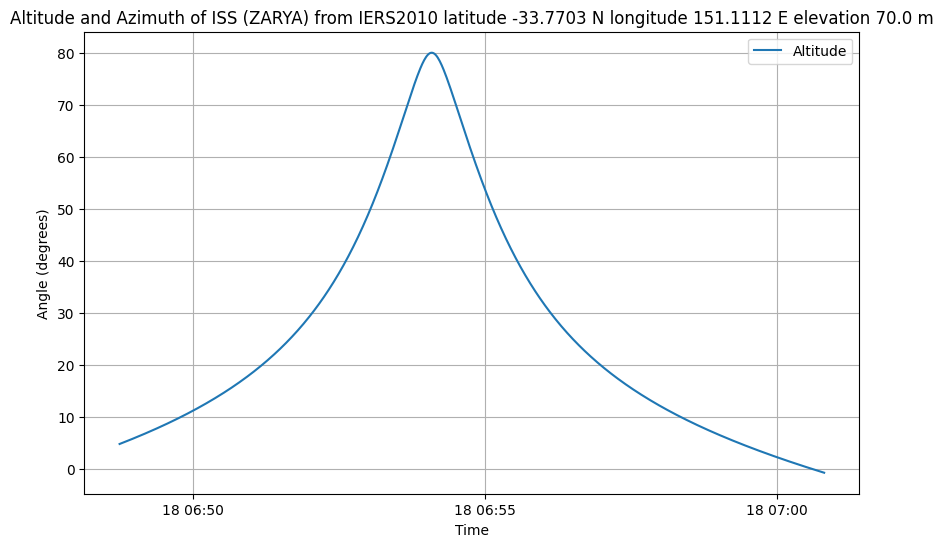

In [21]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import pytz
import math
from math import radians
# Custom TLE data

ts = load.timescale()
satellite = EarthSatellite(tle_line2, tle_line3, name="ISS (ZARYA)")        
observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70)

start_time = list(pd.to_datetime(data['datetimes_sat']))[0] - timedelta(minutes = 6)
end_time = list(pd.to_datetime(data['datetimes_sat']))[-1] + timedelta(minutes = 4)

time_step = timedelta(seconds=1)
times = []
time = start_time
while time < end_time:
    times.append(time)
    time += time_step
    
times2 = []
for timestamp_pd in times:
    TIME_PD = timestamp_pd.replace(tzinfo=pytz.utc)
    time_sf = ts.utc(TIME_PD)
    times2.append(time_sf)

altitudes_line = []
azimuths_line = []
sep_angle_line = []
distance_list_line = []

for time in times2:
    topocentric = (satellite - observer_location).at(time)
    satellite_position = satellite.at(time)
    earth_radius = 6371.0  # Radius of the Earth in kilometers
    satellite_position = satellite.at(time)

    observer_latitude = radians(-33.7703)  # Convert to radians
    observer_longitude = radians(151.1112)  # Convert to radians
    
    earth_radius_km = 6371.0  # Approximate Earth radius in kilometers

    delta_longitude = satellite_position.subpoint().longitude.radians - observer_longitude
    delta_latitude = satellite_position.subpoint().latitude.radians - observer_latitude

    a = (pow(math.sin(delta_latitude / 2), 2) +
         math.cos(observer_latitude) * math.cos(satellite_position.subpoint().latitude.radians) *
         pow(math.sin(delta_longitude / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_list_line.append(distance_km)

    alt, az, _ = topocentric.altaz()
    altitudes_line.append(alt.degrees)
    azimuths_line.append(az.degrees)
    
times_datetime = [t.utc_datetime() for t in times2]

plt.figure(figsize=(10, 6))
plt.plot(times_datetime, altitudes_line, label="Altitude")
#plt.plot(times_datetime, azimuths, label="Azimuth")
plt.xlabel("Time")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.title(f"Altitude and Azimuth of {satellite.name} from {observer_location}")
plt.grid()
plt.show()

In [22]:
from astropy.coordinates.angles import Latitude, Longitude

macquarie_observatory = EarthLocation(lat=-33.7738*u.deg, lon=151.1126*u.deg, height=70*u.m)
sup_seps = []
sun_alt_list = []
sun_az_list = []
for i in np.arange(0,len(list(data['utc'])),1):               
    sun = (get_sun(TiMe(pd.to_datetime(list(data['utc'])[i]))).icrs).transform_to(AltAz(obstime=TiMe(list(data['utc'])[i]),
                                                                                         location=macquarie_observatory))
    sun_alt = sun.alt.deg
    sun_alt_list.append(sun_alt)
    
    sun_az = sun.az.deg
    sun_az_list.append(sun_az)
    
    sun_separation = adnav.angle_between_degrees(AltAz(alt = sun.alt, az=sun.az),
                                                 AltAz(alt = Latitude((list(data['altitude'])[i])*u.deg, unit='deg'), 
                                                       az = Longitude((list(data['azimuth'])[i])*u.deg, unit='deg')))
    sup_seps.append(sun_separation)

In [23]:
sunsep_val = [t.value for t in sup_seps]
data['sunsep'] = sunsep_val

<IPython.core.display.Javascript object>


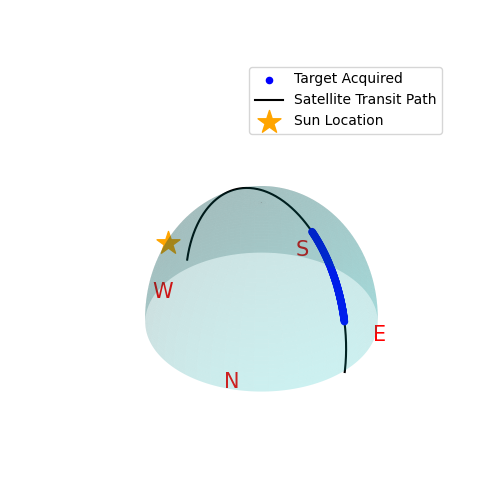

[1.0, 0.0, 4.898587196589413e-17]
[6.123233995736766e-17, 1.0, 4.898587196589413e-17]
[-1.0, 1.2246467991473532e-16, 4.898587196589413e-17]
[-1.8369701987210297e-16, -1.0, 4.898587196589413e-17]


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

#df2 = df2[df2['calibed_mags']<6]

# Sample data (replace with your actual data)
altitude = [30, 60, 90, 45, 30]  # Example altitude values in degrees
azimuth = [45, 90, 180, 270, 360]  # Example azimuth values in degrees

# Convert altitude and azimuth to radians
altitude_rad = np.array((data['altitude'].to_list()*u.deg).to(u.rad))
azimuth_rad = np.array((data['azimuth'].to_list()*u.deg).to(u.rad))
    
# Create a 3D plot with polar projection for azimuth
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection='3d')

# Plot hemisphere surface
phi, theta = np.mgrid[0.0:0.5*np.pi:1000j, 0.0:2.0*np.pi:1000j]
#phi, theta = np.mgrid[0.0:np.pi:1000j, 0.0:2.0*np.pi:1000j]

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = 0.8*np.cos(phi)
ax.plot_surface(x, y, z, color='c', alpha=0.2)

# Plot satellite transit on the hemisphere
x_transit = np.sin(np.pi / 2 - altitude_rad) * np.cos(azimuth_rad)
y_transit = np.sin(np.pi / 2 - altitude_rad) * np.sin(azimuth_rad)
z_transit = np.cos(np.pi / 2 - altitude_rad)
ax.scatter(x_transit, y_transit, 0.8*z_transit, color='b', label='Target Acquired', alpha = 1, marker = 'o')

# Plot satellite transit on the hemisphere
x_transit = np.sin(np.pi / 2 - np.array(np.deg2rad(altitudes_line))) * np.cos(np.deg2rad(np.array(azimuths_line)))
y_transit = np.sin(np.pi / 2 - np.array(np.deg2rad(altitudes_line))) * np.sin(np.deg2rad(np.array(azimuths_line)))
z_transit = np.cos(np.pi / 2 - np.array(np.deg2rad(altitudes_line)))
ax.plot(x_transit, y_transit, 0.8*z_transit, color='black', label='Satellite Transit Path')

x_transit_sun = np.sin(np.pi / 2 - np.mean(np.deg2rad(sun_alt_list))) * np.cos(np.deg2rad(np.mean(sun_az_list)))
y_transit_sun = np.sin(np.pi / 2 - np.mean(np.deg2rad(sun_alt_list))) * np.sin(np.deg2rad(np.mean(sun_az_list)))
z_transit_sun = np.cos(np.pi / 2 - np.mean(np.deg2rad(sun_alt_list)))
ax.scatter(x_transit_sun, y_transit_sun, 0.8*z_transit_sun, color='orange', s=300, label='Sun Location', zorder = 10, marker = '*')


azes = np.array(([0,90,180,270]*u.deg).to(u.rad).value)
alts = np.array(([0,0,0,0]*u.deg).to(u.rad).value)
x_transit = np.sin(np.pi / 2 - alts) * np.cos(azes)
y_transit = np.sin(np.pi / 2 - alts) * np.sin(azes)
z_transit = 0.8*np.cos(np.pi / 2 - alts)
# direction = ['N', 'E', 'S', 'W']
# ax.text(x_transit, y_transit, z_transit, direction, color='r', ha='center', va='center', fontsize=8)#, rotation=90)

# Plot cardinal directions
cardinal_directions = {'N': [x_transit[0],y_transit[0],z_transit[0]],
                       'E': [x_transit[1],y_transit[1],z_transit[1]],
                       'S': [x_transit[2],y_transit[2],z_transit[2]],
                       'W': [x_transit[3],y_transit[3],z_transit[3]]}
for direction, angle in cardinal_directions.items():
    print(angle)
    ax.text(angle[0], angle[1], angle[2], direction, fontsize=15, color='r')

    
# Set plot limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add a legend
ax.legend()
ax.axis(False)
# Show the plot
#plt.savefig("/Users/physarah/Desktop/sat_path.png")
plt.show()

<IPython.core.display.Javascript object>


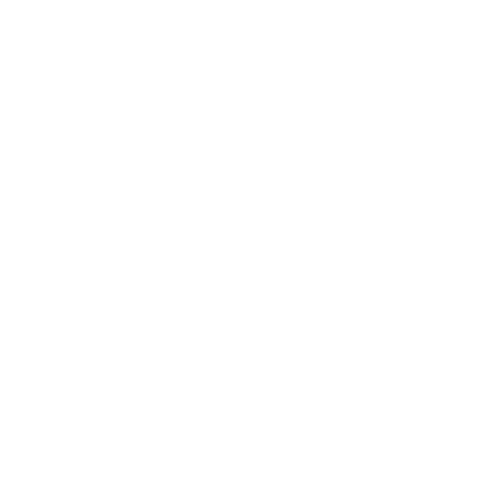

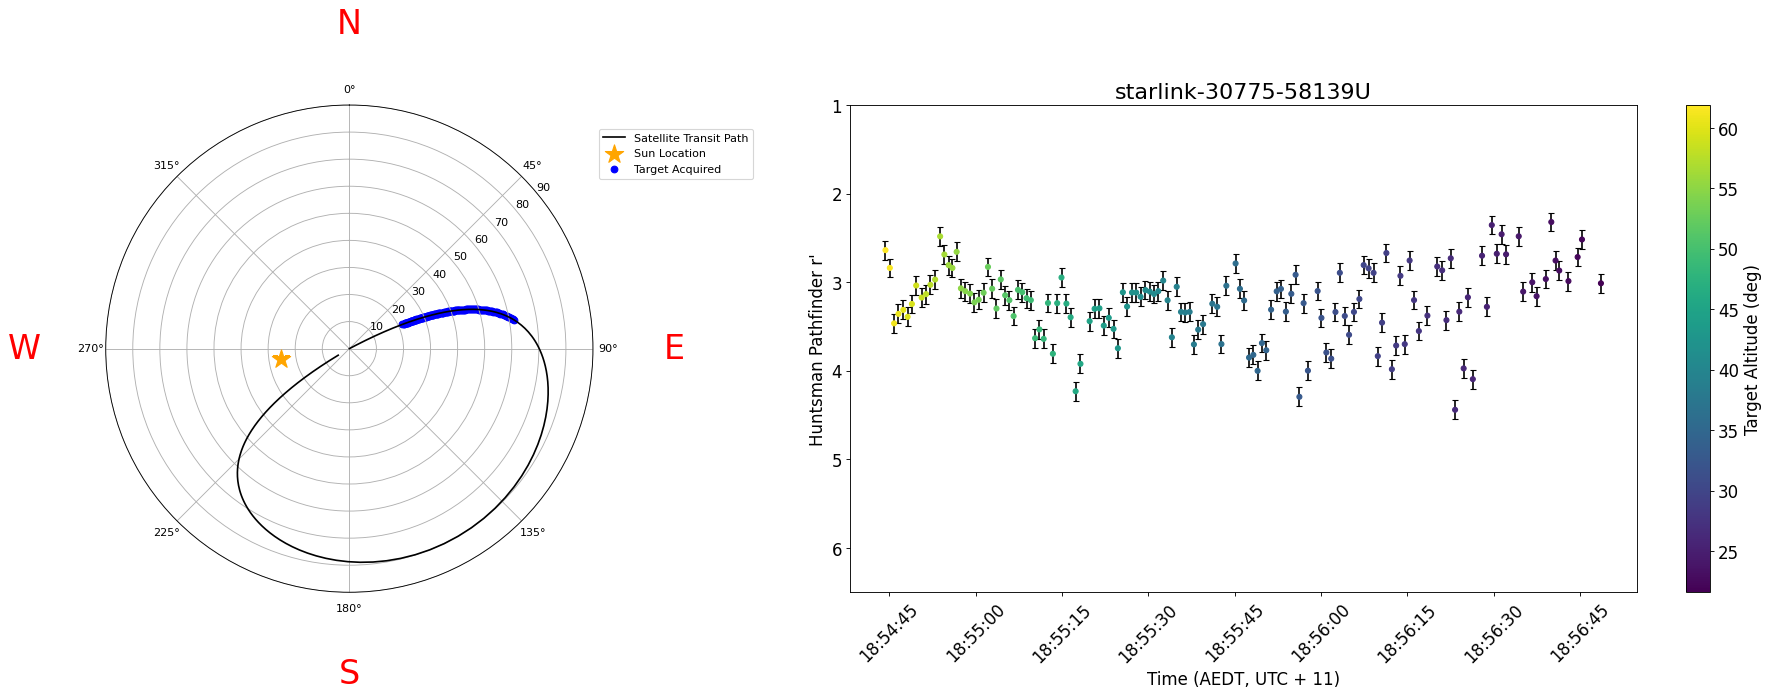

In [25]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


altitude_rad = np.array((data['altitude'].to_list()*u.deg))
azimuth_rad = np.array((data['azimuth'].to_list()*u.deg).to(u.rad))

# Create a polar plot
fig = plt.figure(figsize=(25, 8), dpi=80)

ax = plt.subplot(1,2,1,  projection='polar')

# Plot satellite transit path on the polar plot
ax.plot(np.deg2rad(azimuths_line), (altitudes_line), color='black', label='Satellite Transit Path')

# # Plot sun location on the polar plot
sun_altitude = np.mean(sun_alt_list)  # Example sun altitude in degrees
sun_azimuth = np.deg2rad(np.mean(sun_az_list))  # Example sun azimuth in degrees
ax.scatter(sun_azimuth, sun_altitude, color='orange', s=300, label='Sun Location', zorder=10, marker='*')
ax.scatter(np.deg2rad(data['azimuth']), data['altitude'], color='blue', label = "Target Acquired")

# Plot cardinal directions
cardinal_directions = {'N': 0, 'E': np.pi / 2, 'S': np.pi, 'W': 3 * np.pi / 2}
for direction, angle in cardinal_directions.items():
    ax.text(angle, 120, direction, fontsize=30, color='r', ha='center', va='center')

# Set polar plot labels
ax.set_theta_direction(-1)  # Clockwise direction
ax.set_theta_offset(np.pi / 2)  # Set 0 degree at the top
ax.set_rlabel_position(50)  # Radial labels on the edge
ax.invert_yaxis()
ax.set_ylim(0,90)
# Add a legend
#ax.legend(loc = "upper right")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.9))


plt.subplot(1,2,2)

plt.title("starlink-30775-58139U", fontsize = 20)
plt.errorbar(x = pd.to_datetime(data['datetimes_sat'])-timedelta(hours = 12), y = data['calibed_mags'], yerr=[[error]*len(data['calibed_mags']),
                                                                 [error]*len(data['calibed_mags'])], ls = "", capsize = 3, color = 'black')
plt.scatter(x = pd.to_datetime(data['datetimes_sat'])-timedelta(hours = 12), y = data['calibed_mags'], s = 20, c = data['altitude'], zorder = 10, cmap = 'viridis')
plt.xlabel("Time (AEDT, UTC + 11)", fontsize=15)
plt.ylabel("Huntsman Pathfinder r'", fontsize=15)
cbar = plt.colorbar()
cbar.set_label("Target Altitude (deg)", fontsize=15)
cbar.ax.tick_params(labelsize=15)

plt.xticks(fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
#plt.clim(25,50)
#plt.xlim(pd.to_datetime('2023-03-06 12:24:50'), pd.to_datetime('2023-03-06 12:27:45'))
plt.ylim(6.5,1)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))



plt.savefig("/Users/physarah/Desktop/sat_path_starlink-30775-58139U.png")


In [26]:
data.to_csv("/Users/physarah/Desktop/starlink-30775-58139U-P1.csv")